In [61]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs


# define els_obs as an object containing x_normals and y_normals with same as size as n_pts
class els_normals:
    def __init__(self, els, n):
        n_els = len(els.x1)
        self.x = np.zeros(n_els * n)
        self.y = np.zeros(n_els * n)
        self.x_shears = np.zeros(n_els * n)
        self.y_shears = np.zeros(n_els * n)
        self.x_normals = np.zeros(n_els * n)
        self.y_normals = np.zeros(n_els * n)
        self.lengths = np.zeros(n_els * n)

        for i in range(n_els):
            xvec = np.linspace(els.x1[i], els.x2[i], n + 1)
            yvec = np.linspace(els.y1[i], els.y2[i], n + 1)
            self.x[i * n : (i + 1) * n] = 0.5 * (xvec[1:] + xvec[0:-1])
            self.y[i * n : (i + 1) * n] = 0.5 * (yvec[1:] + yvec[0:-1])
            self.x_shears[i * n : (i + 1) * n] = els.x_shears[i]
            self.y_shears[i * n : (i + 1) * n] = els.y_shears[i]
            self.x_normals[i * n : (i + 1) * n] = els.x_normals[i]
            self.y_normals[i * n : (i + 1) * n] = els.y_normals[i]
            self.lengths[i * n : (i + 1) * n] = els.lengths[i] / n


def extract_quadratic_components(quadratic_coefs, n_els):
    # extract (s,n) components and store them in 2 separate vectors
    quadratic_coefs_s = np.zeros((3 * n_els, 1))
    quadratic_coefs_n = np.zeros((3 * n_els, 1))
    for i in range(n_els):
        quadratic_coefs_s[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i : 6 * i + 3]
        quadratic_coefs_n[3 * i : 3 * (i + 1)] = quadratic_coefs[
            6 * i + 3 : 6 * (i + 1)
        ]

    return quadratic_coefs_s, quadratic_coefs_n

# Construct a fault inside an arbitrary sized box domain

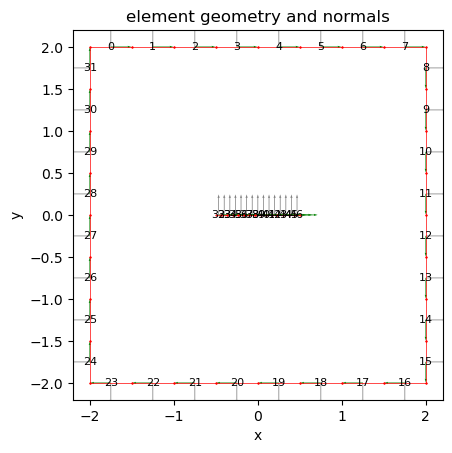

In [62]:
# Create a box mesh with a sinusoidal fault in the middle
L = 2.0
H = L * 1.0
ngrid = 4
corners = np.array([[-L, H], [L, H], [L, -H], [-L, -H], [-L, H]])

# Create arrays of the x and y coordinates of the corners
x, z = [], []
for i in range(4):
    lsegment = np.sqrt(
        (corners[i, 0] - corners[(i + 1), 0]) ** 2
        + (corners[i, 1] - corners[(i + 1), 1]) ** 2
    )
    xi = np.linspace(
        corners[i][0],
        corners[(i + 1) % 4][0],
        num=round(lsegment * ngrid / H),
        endpoint=False,
    )
    zi = np.linspace(
        corners[i][1],
        corners[(i + 1) % 4][1],
        num=round(lsegment * ngrid / H),
        endpoint=False,
    )
    x.append(xi)
    z.append(zi)
x.append(corners[0, 0])
z.append(corners[0, 1])
x = np.hstack(x)
z = np.hstack(z)

x1_box = x[0:-1]
x2_box = x[1:]
y1_box = z[0:-1]
y2_box = z[1:]

# Across the middle: Create a sinusoidal fault centered around y=0
Lfault = 1.0
x = np.linspace(-0.5 * Lfault, 0.5 * Lfault, int(4 * ngrid))
z = 0.0 * Lfault * np.sin(4 * np.pi * x / 2 / Lfault)
x1_across = x[0:-1]
x2_across = x[1:]
y1_across = z[0:-1]
y2_across = z[1:]

# Elastic parameters
mu = 1
nu = 0.25

els = bemcs.initialize_els()
els.x1 = np.concatenate([x1_box, x1_across])
els.y1 = np.concatenate([y1_box, y1_across])
els.x2 = np.concatenate([x2_box, x2_across])
els.y2 = np.concatenate([y2_box, y2_across])

bemcs.standardize_els_geometry(els, reorder=False)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)

# Imposed tractions as BC (specified in $x,y$ direction)

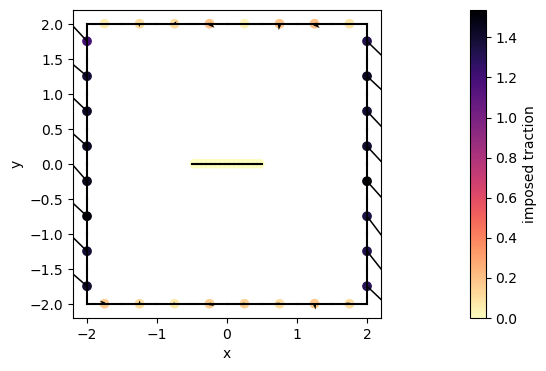

In [63]:
# Traction imposed at central nodes of each patch (these are in x,y coordinates)
np.random.seed(42)
traction_vector_x = np.hstack(
    [
        np.random.normal(
            loc=els.x_normals[0 : len(x1_box)], scale=0.1, size=np.shape(x1_box)
        ),
        np.zeros_like(x1_across),
    ]
)
traction_vector_y = np.hstack(
    [
        np.random.normal(
            loc=-els.x_normals[0 : len(x1_box)], scale=0.1, size=np.shape(x1_box)
        ),
        np.zeros_like(x1_across),
    ]
)

plt.figure(figsize=(23, 4))
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-")
plt.scatter(
    els.x_centers,
    els.y_centers,
    c=np.sqrt(traction_vector_x**2 + traction_vector_y**2),
    marker="o",
    cmap="magma_r",
)
plt.colorbar(label="imposed traction")
plt.quiver(
    els.x_centers, els.y_centers, traction_vector_x, traction_vector_y, width=0.005
)
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

# BEMCS labels nodes and calculates kernels

In [64]:
index_open, index_overlap, index_triple = bemcs.label_nodes(els)
N_c = 2 * n_els  # central node equations
N_o = 2 * len(index_open)  # open node equations
N_i = 4 * len(index_overlap)  # overlapping node equations
N_t = 6 * len(index_triple)  # triple junction equations

Nequations = N_c + N_o + N_i + N_t
Nunknowns = 6 * n_els

# We will stack this with
# equations for the element centers
# equations at open nodes (RHS = 0)
# equations at overlapping nodes (RHS = 0)
# equations at triple junctions (RHS = 0)
BC_c = np.zeros((N_c, 1))  # these are the only non-zero entries
BC_o = np.zeros((N_o, 1))
BC_i = np.zeros((N_i, 1))
BC_t = np.zeros((N_t, 1))

# apply BCs at central nodes
BC_c[0::2, 0] = traction_vector_x
BC_c[1::2, 0] = traction_vector_y

# stack all the BCs into 1 big vector
BCvector = np.vstack((BC_c, BC_o, BC_i, BC_t))

# Design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
matrix_slip, matrix_slip_gradient = bemcs.get_matrices_slip_slip_gradient(
    els, reference="local"
)

# Patch center locations
obs_xy = np.vstack((els.x_centers, els.y_centers)).T
x_obs = obs_xy[:, 0].reshape(-1, 1)
y_obs = obs_xy[:, 1].reshape(-1, 1)

# Compute shear and tensile stress kernels evaluated ONLY at the center of each element
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")

# Convert to traction kernels [Nobs x Ncoefficients]
traction_kernels_s = bemcs.get_traction_kernels(els, kernels_s, flag="global")
traction_kernels_n = bemcs.get_traction_kernels(els, kernels_n, flag="global")

Number of open nodes = 2
: [array([96]), array([140])]
Number of 2-overlap nodes = 46
: [array([ 72, -71]), array([ 75, -74]), array([ 78, -77]), array([ 81, -80]), array([ 84, -83]), array([ 87, -86]), array([ 90, -89]), array([ 93, -92]), array([  0, -95]), array([ 69, -68]), array([ 3, -2]), array([ 66, -65]), array([ 6, -5]), array([ 63, -62]), array([ 9, -8]), array([ 99, -98]), array([ 102, -101]), array([ 105, -104]), array([ 108, -107]), array([ 111, -110]), array([ 114, -113]), array([ 117, -116]), array([ 60, -59]), array([ 12, -11]), array([ 120, -119]), array([ 123, -122]), array([ 126, -125]), array([ 129, -128]), array([ 132, -131]), array([ 135, -134]), array([ 138, -137]), array([ 57, -56]), array([ 15, -14]), array([ 54, -53]), array([ 18, -17]), array([ 51, -50]), array([ 21, -20]), array([ 48, -47]), array([ 45, -44]), array([ 42, -41]), array([ 39, -38]), array([ 36, -35]), array([ 33, -32]), array([ 30, -29]), array([ 27, -26]), array([ 24, -23])]
Number of triple 

# Assemble the design matrix and boundary conditions

In [65]:
# Linear Operators for the appropriate boundary conditions
matrix_system_c = np.zeros((N_c, Nunknowns))

matrix_system_o, matrix_system_i, matrix_system_t = bemcs.construct_smoothoperator(
    els, index_open, index_overlap, index_triple
)

# Linear operator for central node BCs
kerneleval_x = np.zeros((n_els, Nunknowns))
kerneleval_y = np.zeros((n_els, Nunknowns))

# all kernels are global traction kernels only
for k in range(0, 3):
    kerneleval_x[:, k::6] = traction_kernels_s[0][:, k::3]
    kerneleval_x[:, k + 3 :: 6] = traction_kernels_n[0][:, k::3]
    kerneleval_y[:, k::6] = traction_kernels_s[1][:, k::3]
    kerneleval_y[:, k + 3 :: 6] = traction_kernels_n[1][:, k::3]

# populate matrix_system for central nodes
matrix_system_c[0::2, :] = kerneleval_x
matrix_system_c[1::2, :] = kerneleval_y

# stack the matrices and create the full linear operator
matrix_system = np.vstack(
    (matrix_system_c, matrix_system_o, matrix_system_i, matrix_system_t)
)
# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.pinv(matrix_system) @ BCvector
# quadratic_coefs = np.linalg.lstsq(matrix_system, BCvector)[0]
print("Linear Operator Condition Number:", np.linalg.cond(matrix_system))
dummy = matrix_system @ quadratic_coefs

# evaluate slip and traction on finer mesh
# create finely discretized observation points on els
n_eval = 4
els_obs = els_normals(els, n_eval)
_, _, sx, sy = bemcs.get_slipvector_on_fault(els, quadratic_coefs.flatten(), n_eval)

Linear Operator Condition Number: 8.278192594680898e+16


# Plot displacements and stresses

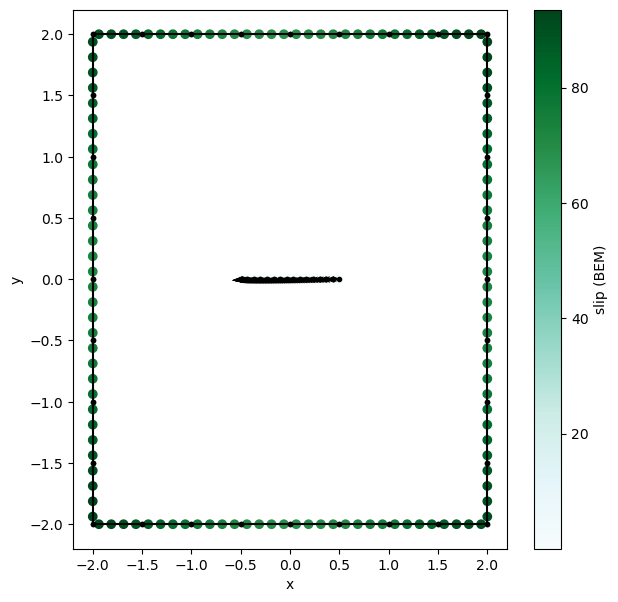

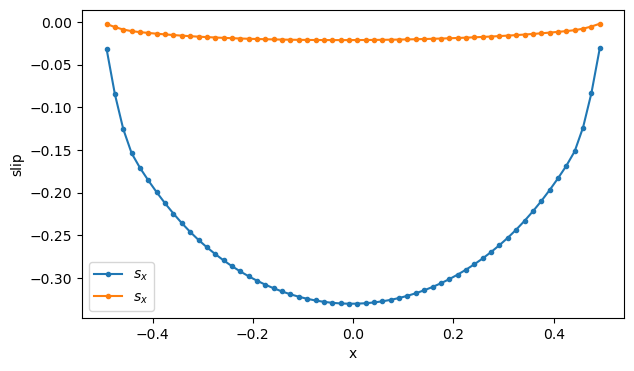

In [66]:
faultindex = np.arange((n_els - len(x1_across)) * n_eval, n_els * n_eval)

plt.figure(figsize=(7, 7))
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k.-")
plt.scatter(
    els_obs.x,
    els_obs.y,
    c=np.sqrt(sx**2 + sy**2),
    marker="o",
    cmap="BuGn",
)
plt.colorbar(label="slip (BEM)")
plt.quiver(
    els_obs.x[faultindex],
    els_obs.y[faultindex],
    sx[faultindex],
    sy[faultindex],
    width=0.005,
)
plt.xlabel("x")
plt.ylabel("y")
# plt.gca().set_aspect("equal", adjustable="box")
plt.show()

# plot fault slip
plt.figure(figsize=(7, 4))
plt.plot(els_obs.x[faultindex], sx[faultindex], ".-", label="$s_x$")
plt.plot(els_obs.x[faultindex], sy[faultindex], ".-", label="$s_x$")
plt.xlabel("x")
plt.ylabel("slip")
plt.legend()
plt.show()